In [1]:
import torch
from environment_batched import BatchedMarket, BatchedLeontief, BatchedFirm, BatchedEnvironment
from models.policy import BetaPolicyNetwork, DeterministicPolicyNetwork, BetaPolicyNetwork2
from models.critic import CentralizedCritic, CentralizedCritic2
from models.utils import get_state, get_state_dim, process_actions, get_action_dim
from trainer import TrainerAC, TrainerSAC, Trainer3
from utils.plotting import plot_actions, plot_environment

In [10]:
torch.manual_seed(123)
torch.backends.cudnn.deterministic = True
device = 'cuda'
market_kwargs = dict(start_volumes=10, base_price=10, start_gains=100, deprecation_steps=3)
prod_functions = [
    BatchedLeontief(torch.tensor([1, 0]), torch.tensor([0, 2]), device=device),
    BatchedLeontief(torch.tensor([0, 1]), torch.tensor([2, 0]), device=device),
]
invest_functions = [
    BatchedLeontief(torch.tensor([1, 1]), torch.tensor(1), device=device),
    BatchedLeontief(torch.tensor([1, 1]), torch.tensor(1), device=device),
]
env = BatchedEnvironment(market_kwargs,
                         BetaPolicyNetwork2,
                         prod_functions,
                         invest_functions=invest_functions,
                         batch_size=512)
critic = CentralizedCritic2
trainer = TrainerSAC(env, q_critic=critic, batch_size=512)

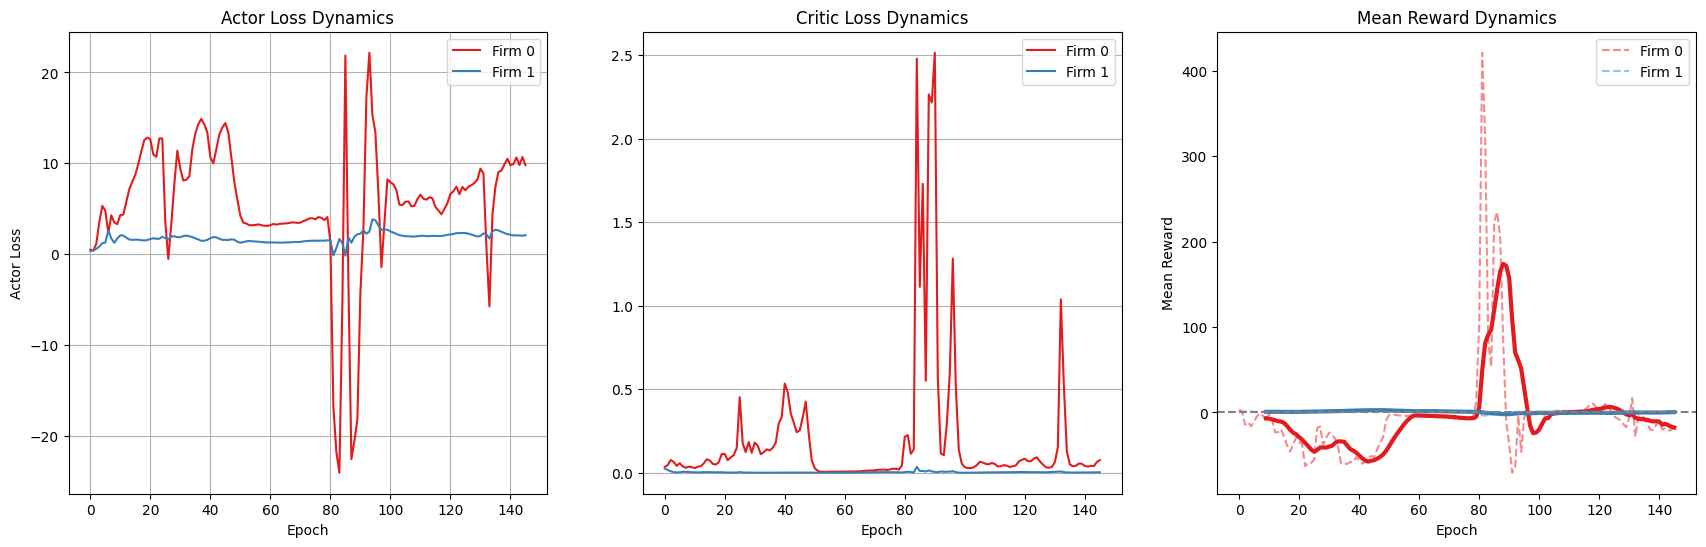

 11%|████████▋                                                                     | 111/1000 [09:43<1:13:30,  4.96s/it, LR=0.00028573747375370444]

In [ ]:
env.change_batch_size(512)
env.reset()
trainer.train(1000, episode_length=50)

In [12]:
env = BatchedEnvironment(market_kwargs,
                         BetaPolicyNetwork2,
                         prod_functions,
                         invest_functions=invest_functions,
                         batch_size=512)
env.reset()
env.change_batch_size(1)
env.market.price_matrix.fill_(10)
env.firms

[Firm id: 0
 Reserves: [[10, 10]]
 Finance: tensor([[100]], device='cuda:0')
 Limit: tensor([[1]], device='cuda:0')
 Capital: [tensor([3])],
 Firm id: 1
 Reserves: [[10, 10]]
 Finance: tensor([[100]], device='cuda:0')
 Limit: tensor([[1]], device='cuda:0')
 Capital: [tensor([3])]]

In [13]:

n_periods = 100
for i in range(n_periods):
    env.step_and_record(i % env.market.n_firms)
env.firms

[Firm id: 0
 Reserves: [[0, 1]]
 Finance: tensor([[157]], device='cuda:0')
 Limit: tensor([[0]], device='cuda:0')
 Capital: [tensor([], dtype=torch.int64)],
 Firm id: 1
 Reserves: [[1, 0]]
 Finance: tensor([[43]], device='cuda:0')
 Limit: tensor([[0]], device='cuda:0')
 Capital: [tensor([], dtype=torch.int64)]]

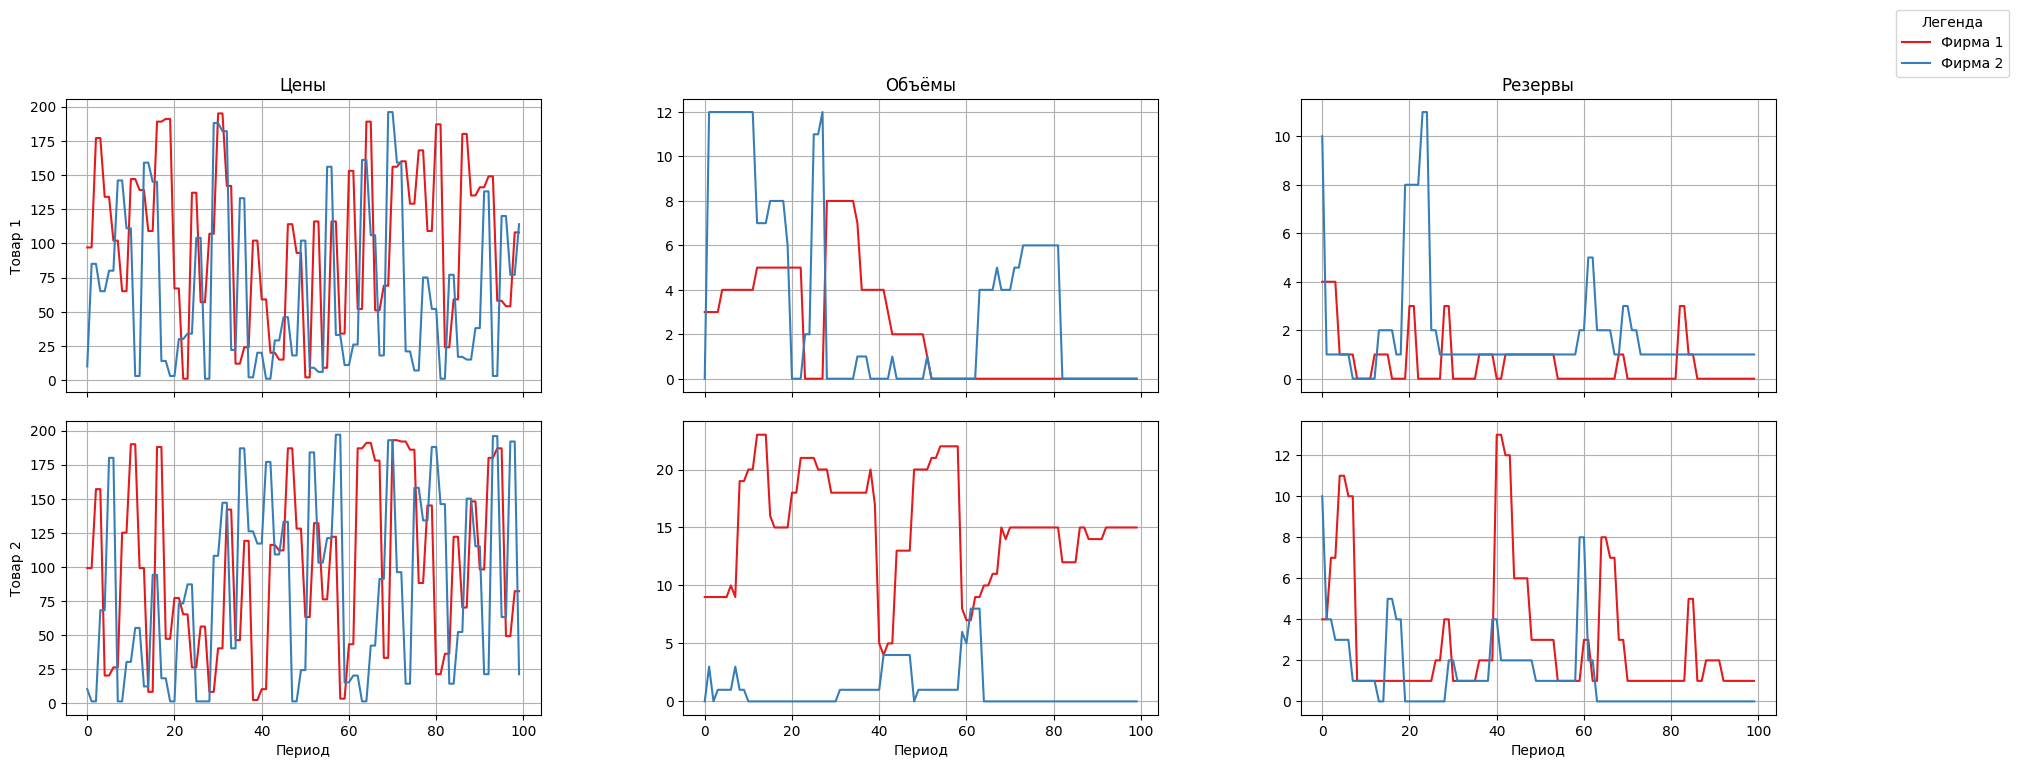

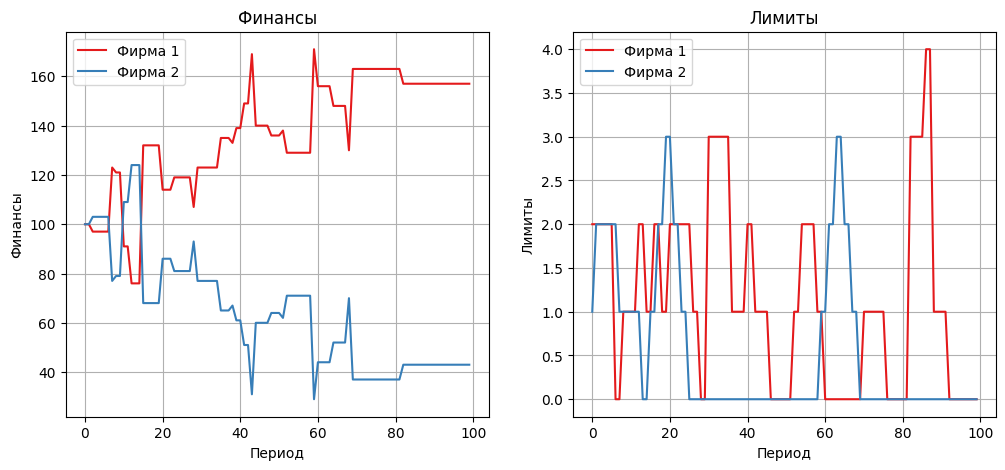

In [14]:
from utils.plotting import plot_actions, plot_environment

plot_environment(env.state_history)

In [15]:
env.firms[0].financial_resources

tensor([[157]], device='cuda:0')

In [16]:
env.firms[1].financial_resources

tensor([[43]], device='cuda:0')

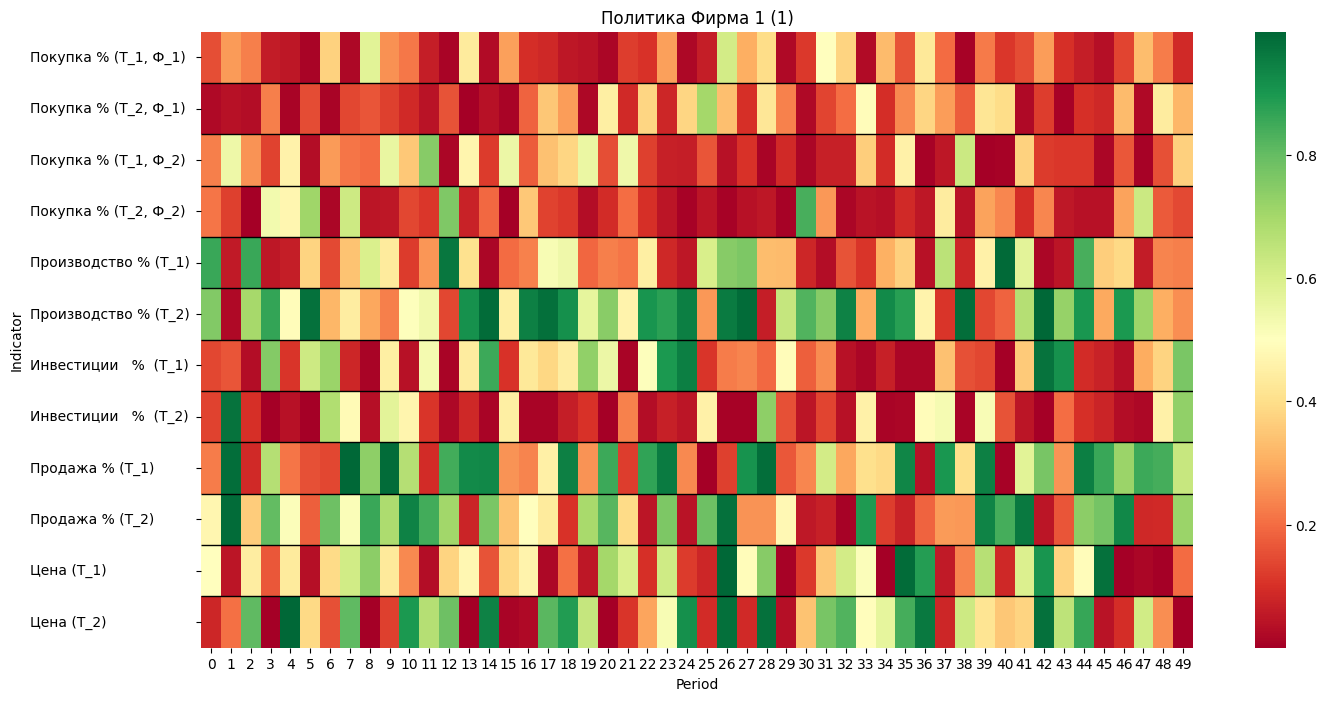

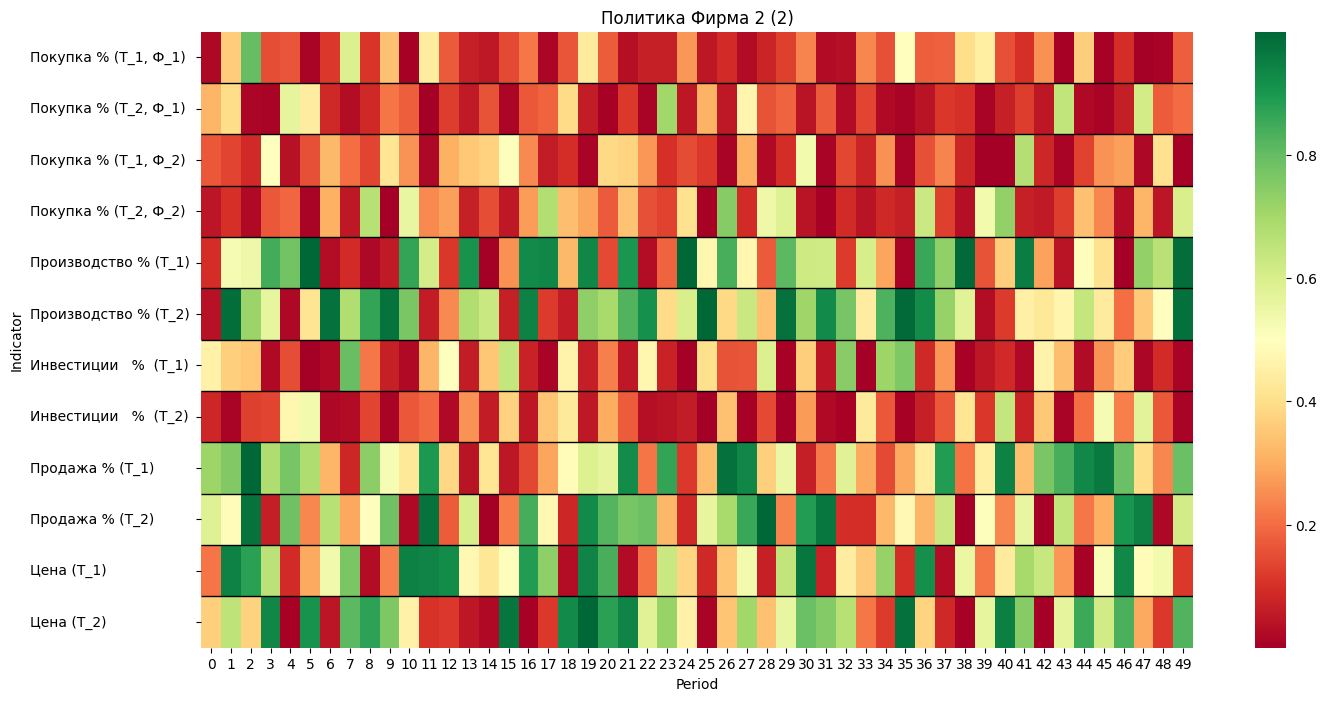

In [9]:
plot_actions(env.actions_history[0], 'Политика Фирма 1 (1)')
plot_actions(env.actions_history[1], 'Политика Фирма 2 (2)')